In [1]:



import wandb
import pandas as pd
import re
import datetime
from dateutil import relativedelta
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import math
import json




In [2]:
scene_list  =  ['20200412T101835_cis','20201210T212044_dmi','20210727T104206_cis','20201119T120712_cis',
                '20180929T081203_dmi','20210720T211851_dmi','20200223T205225_dmi','20181212T205512_dmi',
                '20200424T101936_cis','20181009T181132_dmi','20180907T120359_cis','20191012T081214_dmi',
                '20180531T122930_cis','20190924T130739_cis','20190105T102726_cis','20180621T214132_cis',
                '20200809T205232_dmi','20210905T203605_dmi','20210203T104018_dmi','20190922T155400_cis']   

database = "datalists/dataset.json"

def get_location(scene,database):
    """
    This function retrieves the location from a scene based on a predefined list of locations.

    Parameters:
    scene (str): The name of the scene.
    database (str): The path to the JSON file that contains the full list of scenes.

    Returns:
    str: The location if found in the scene. If multiple locations are found, it returns the first one. 
         If no location is found, it returns the last location in the predefined list.

    Note:
    The function uses a tpredefined list of locations to search in the scenes. 
    It splits the input scene string into parts using underscore (_) as separator and checks if these parts exist in any scene from the database.
    It then checks if any location from the predefined list exists in the scene.
    """

    locations = ['SGRDIEA','SGRDIFOXE', 'SGRDIHA', 'SGRDIMID', 'SGRDINFLD', 'SGRDIWA', 'CentralEast_RIC', 
                 'SouthEast_RIC', 'CentralWest_RIC', 'CapeFarewell_RIC', 'NorthWest_RIC', 'Qaanaaq_RIC', 
                 'NorthEast_RIC', 'NorthAndCentralEast_RIC', 'North_RIC']



    scene_parts = scene.split('_')

    with open(database) as file:
        full_scene_list = json.loads(file.read())

    for full_scene in full_scene_list:
        if scene_parts[0] in full_scene and scene_parts[0] in full_scene:
            break

    for loc in locations: 
        if loc in full_scene:
            break
    return loc


for scene in scene_list:
    loc = get_location(scene,database)
    print('------------------')
    print(scene)
    print(loc)

  


------------------
20200412T101835_cis
SGRDIEA
------------------
20201210T212044_dmi
NorthWest_RIC
------------------
20210727T104206_cis
SGRDIEA
------------------
20201119T120712_cis
SGRDIFOXE
------------------
20180929T081203_dmi
CentralEast_RIC
------------------
20210720T211851_dmi
North_RIC
------------------
20200223T205225_dmi
CapeFarewell_RIC
------------------
20181212T205512_dmi
NorthWest_RIC
------------------
20200424T101936_cis
SGRDINFLD
------------------
20181009T181132_dmi
CentralEast_RIC
------------------
20180907T120359_cis
SGRDIFOXE
------------------
20191012T081214_dmi
CentralEast_RIC
------------------
20180531T122930_cis
SGRDIFOXE
------------------
20190924T130739_cis
SGRDIMID
------------------
20190105T102726_cis
SGRDIEA
------------------
20180621T214132_cis
SGRDINFLD
------------------
20200809T205232_dmi
CapeFarewell_RIC
------------------
20210905T203605_dmi
CapeFarewell_RIC
------------------
20210203T104018_dmi
CentralWest_RIC
------------------
2019

In [3]:
def performace_per_location(path,group,database):
    """
    This function calculates the average performance scores per month for a given group of runs.

    Parameters:
    path (str): The path to the runs in the Weights & Biases (wandb) project.
    group (str): The group of runs to consider.

    Returns:
    mean_dic: A dictionary containing the following:
        - months: list of the months (1,2,3,4..) that are in the data.
        - Metrics ( Combine Score, SIC, SOD, and FLOE). Each metric contains the following
            - Avg: The average score for each month
            - Std: The Standard deviation for each month
            - Array: All the scores belonging to each month. A list of numpy arrays. 
        - Sample Number: The number of scenes for each month. A list of positive intergers
        - Scenes: The name of the scenes used in each month. A list of lists. Each inner list containing the names of the scenes. 
    the average scores and standard deviations for each metric per month.
    relative_mean_dic: The only difference is that is measure the increase or decrease performace relative to the mean of each run
    """

    locations = ['SGRDIEA','SGRDIFOXE', 'SGRDIHA', 'SGRDIMID', 'SGRDINFLD', 'SGRDIWA', 'CentralEast_RIC', 
                 'SouthEast_RIC', 'CentralWest_RIC', 'CapeFarewell_RIC', 'NorthWest_RIC', 'Qaanaaq_RIC', 
                 'NorthEast_RIC', 'NorthAndCentralEast_RIC', 'North_RIC']

    # open the wandb api
    api = wandb.Api()

    # Get the runs
    runs = api.runs(path=path,filters={'group':group})
    
    # Log all the validation artifacts
    val_df=[]

    # Get the validation tables for each run
    for run in runs:
        artifacts = run.logged_artifacts()

        # Try to get the artifacts in each run. Sometimes it is not possible. 
        try:
            for artifact in artifacts:


                    if artifact.type == 'run_table':
                        if 'val' in artifact.name:
                            df = artifact.get('val results table').get_dataframe()
                            df.attrs = {'name':run.id}
                            val_df.append(df)
                            print('appended val table')
        except:
            print(f'Error happened. Run:{run}')

    # Subtract the mean of each table
    val_mean_df = val_df
    val_relative_mean_df = []

    for df in val_df:
        mean_values = df.iloc[:,1:].mean()
        df_mean_sub = df.copy()
        df_mean_sub.iloc[:,1:] = df_mean_sub.iloc[:,1:] - mean_values
        val_relative_mean_df.append(df_mean_sub)
    
    # Calculate the avg scores per month
    avg_scores_by_loc = {}
    relative_avg_scores_by_loc = {}

    # Create the dictionaries that will hold the data
    dic = {'array':[],'avg':None,'std':None}
    metrics =  ['Combine Score','SIC','SOD','FLOE',]

    # Create the dictionaries to store the data
    for loc in locations:
        avg_scores_by_loc[loc] = {'Combine Score':deepcopy(dic), 'SIC':deepcopy(dic), 'SOD':deepcopy(dic), 'FLOE':deepcopy(dic),'scenes':[],'sample_num':0}
        relative_avg_scores_by_loc[loc] = {'Combine Score':deepcopy(dic),'SIC':deepcopy(dic),'SOD':deepcopy(dic),'FLOE':deepcopy(dic),'scenes':[],'sample_num':0}


    # Add all the scores and scenes by month
    for df in val_mean_df:
        for i in range(0,df.shape[0]):
            loc = get_location(df.loc[i,'Scene'],database)
            avg_scores_by_loc[loc]['scenes'].append(df.loc[i,'Scene'])
            if math.isnan(df.loc[i,'Combine Score']):
                continue
            for metric in metrics:
                avg_scores_by_loc[loc][metric]['array'].append(df.loc[i,metric])
  
    
    
    # Add all the scores, scenes by month for relative scores
    for df in val_relative_mean_df:
        for i in range(0,df.shape[0]):
            loc = get_location(df.loc[i,'Scene'],database)
            if math.isnan(df.loc[i,'Combine Score']):
                continue
            for metric in metrics:
                relative_avg_scores_by_loc[loc][metric]['array'].append(df.loc[i,metric])

        

    # Obtain the average and std
    for location_dict in avg_scores_by_loc.values():
        location_dict['sample_num'] =  len(location_dict[metrics[0]]['array'])
        for metric_dict in location_dict.values():
            if isinstance(metric_dict,dict):
                metric_dict['array'] = np.array(metric_dict['array'])
                metric_dict['avg'] = metric_dict['array'].mean()
                metric_dict['std'] = metric_dict['array'].std()

    for location_dict in relative_avg_scores_by_loc.values():
        location_dict['sample_num'] =  len(location_dict[metrics[0]]['array'])
        for metric_dict in location_dict.values():
            if isinstance(metric_dict,dict):
                metric_dict['array'] = np.array(metric_dict['array'])
                metric_dict['avg'] = metric_dict['array'].mean()
                metric_dict['std'] = metric_dict['array'].std()

    # Convert the format of the data instead of a dictionary into a lists for easier ploting
    mean_dic = {'Locations':[],
                'Combine Score':{'avg':[],'std':[],'array':[]},
                'SIC':{'avg':[],'std':[],'array':[]},
                'SOD':{'avg':[],'std':[],'array':[]},
                'FLOE':{'avg':[],'std':[],'array':[]},
                'scenes':[],
                'sample_num':[]
    }

    relative_mean_dic = {'Locations':[],
                'Combine Score':{'avg':[],'std':[],'array':[]},
                'SIC':{'avg':[],'std':[],'array':[]},
                'SOD':{'avg':[],'std':[],'array':[]},
                'FLOE':{'avg':[],'std':[],'array':[]},
                'scenes':[],
                'sample_num':[]
    }



    for loc in avg_scores_by_loc.keys():

        mean_dic['Locations'].append(loc)

        [cs,sic,sod,floe,sc,sn] = avg_scores_by_loc[loc].keys()

        mean_dic[cs]['avg'].append(avg_scores_by_loc[loc][cs]['avg'])
        mean_dic[cs]['std'].append(avg_scores_by_loc[loc][cs]['std'])
        mean_dic[cs]['array'].append(avg_scores_by_loc[loc][cs]['array'])

        mean_dic[sic]['avg'].append(avg_scores_by_loc[loc][sic]['avg'])
        mean_dic[sic]['std'].append(avg_scores_by_loc[loc][sic]['std'])
        mean_dic[sic]['array'].append(avg_scores_by_loc[loc][sic]['array'])

        mean_dic[sod]['avg'].append(avg_scores_by_loc[loc][sod]['avg'])
        mean_dic[sod]['std'].append(avg_scores_by_loc[loc][sod]['std'])
        mean_dic[sod]['array'].append(avg_scores_by_loc[loc][sod]['array'])

        mean_dic[floe]['avg'].append(avg_scores_by_loc[loc][floe]['avg'])
        mean_dic[floe]['std'].append(avg_scores_by_loc[loc][floe]['std'])
        mean_dic[floe]['array'].append(avg_scores_by_loc[loc][floe]['array'])

        mean_dic[sn].append(avg_scores_by_loc[loc][sn])
        mean_dic[sc].append(avg_scores_by_loc[loc][sc])

    for loc in relative_avg_scores_by_loc.keys():

        relative_mean_dic['Locations'].append(loc)

        [cs,sic,sod,floe,sc,sn] = relative_avg_scores_by_loc[loc].keys()

        relative_mean_dic[cs]['avg'].append(relative_avg_scores_by_loc[loc][cs]['avg'])
        relative_mean_dic[cs]['std'].append(relative_avg_scores_by_loc[loc][cs]['std'])
        relative_mean_dic[cs]['array'].append(relative_avg_scores_by_loc[loc][cs]['array'])

        relative_mean_dic[sic]['avg'].append(relative_avg_scores_by_loc[loc][sic]['avg'])
        relative_mean_dic[sic]['std'].append(relative_avg_scores_by_loc[loc][sic]['std'])
        relative_mean_dic[cs]['array'].append(relative_avg_scores_by_loc[loc][cs]['array'])

        relative_mean_dic[sod]['avg'].append(relative_avg_scores_by_loc[loc][sod]['avg'])
        relative_mean_dic[sod]['std'].append(relative_avg_scores_by_loc[loc][sod]['std'])
        relative_mean_dic[sod]['array'].append(relative_avg_scores_by_loc[loc][sod]['array'])

        relative_mean_dic[floe]['avg'].append(relative_avg_scores_by_loc[loc][floe]['avg'])
        relative_mean_dic[floe]['std'].append(relative_avg_scores_by_loc[loc][floe]['std'])
        relative_mean_dic[floe]['array'].append(relative_avg_scores_by_loc[loc][floe]['array'])

        relative_mean_dic[sn].append(relative_avg_scores_by_loc[loc][sn])
        relative_mean_dic[sc].append(relative_avg_scores_by_loc[loc][sc])

    return mean_dic , relative_mean_dic

database = "datalists/dataset.json"
path = 'ai4arctic/feature_selection_enviroment_rerun'
group = 'HH_HV_only'

HH_HV_mean_dic, HH_HV_relative_mean_dic = performace_per_location(path,group,database)


path = 'ai4arctic/feature_selection_rerun_inference'
group = 'HH_HV_Location'



Location_mean_dic, Location_relative_mean_dic = performace_per_location(path,group,database)


path = 'ai4arctic/feature_selection_base'
group = 'HH_HV_Time_Location'

Time_Location_mean_dic, Time_Location_relative_mean_dic = performace_per_location(path,group,database)



wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


/tmp/ipykernel_1215319/342030091.py:106: RuntimeWarning: Mean of empty slice.
  metric_dict['avg'] = metric_dict['array'].mean()
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1215319/342030091.py:114: Runtim

appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


,Locations,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,SGRDIEA,79.732213,19.516938,85.655133,24.503414,78.161413,21.053785,71.027840,23.715393,75
1,SGRDIFOXE,78.354431,19.052661,90.922969,12.536119,68.949093,30.990365,72.027969,30.127252,65
2,SGRDIHA,86.497500,17.484506,90.023615,12.614020,82.749615,23.026653,86.941346,18.978072,26
3,SGRDIMID,78.554600,16.570371,79.944143,17.076569,76.381657,20.171575,80.120857,19.239542,35
4,SGRDINFLD,86.253220,11.183719,92.470220,7.201260,84.248272,17.664412,77.828881,17.536161,59
5,SGRDIWA,86.170114,14.003006,93.668022,4.704082,82.598159,21.112156,78.318136,25.981504,44
6,CentralEast_RIC,83.639125,11.270149,87.056750,10.709536,83.869458,14.236696,76.343250,19.719809,72
7,SouthEast_RIC,92.933643,11.042105,95.982999,3.855937,91.804714,19.929641,89.092976,16.078856,42
8,CentralWest_RIC,92.070119,8.103441,92.312525,9.056945,91.593627,9.922703,92.538305,8.761135,59
9,CapeFarewell_RIC,98.929593,2.555467,98.992815,2.187869,99.137778,2.587209,98.386778,4.298460,54


,Locations,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,SGRDIEA,80.560574,23.426277,85.036093,34.959023,78.534463,25.875145,75.661851,22.901511,54
1,SGRDIFOXE,83.548338,17.887549,93.746279,6.698110,77.004530,30.968080,76.240353,30.272138,68
2,SGRDIHA,87.340875,16.242326,90.006594,13.704277,84.035563,20.873114,88.619938,15.703781,32
3,SGRDIMID,83.794343,12.505236,86.991257,11.616028,80.090857,17.179717,84.807685,13.681071,35
4,SGRDINFLD,88.776802,10.140700,92.576803,7.348226,89.656605,15.264436,79.417066,16.007848,76
5,SGRDIWA,86.956352,9.893330,90.280778,10.395312,87.102889,12.103778,80.014241,22.588561,54
6,CentralEast_RIC,85.243285,10.090389,87.827651,10.110937,85.001778,13.012682,80.557333,18.150548,63
7,SouthEast_RIC,93.479755,9.778858,93.191265,12.442296,95.118183,9.475205,90.779857,14.440666,49
8,CentralWest_RIC,84.525422,12.075505,88.718022,9.282871,78.270689,24.180836,88.649911,9.190649,45
9,CapeFarewell_RIC,99.281085,1.774863,99.312766,1.565235,99.418681,1.613794,98.942405,3.078502,47


,Locations,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,SGRDIEA,90.502449,8.501886,93.750265,5.719315,90.725142,12.964424,83.561408,18.611886,49
1,SGRDIFOXE,88.775871,12.018905,92.792971,7.300235,86.923414,17.707594,84.446585,21.411450,70
2,SGRDIHA,91.650727,12.091193,92.906363,11.830656,90.496606,13.069947,91.447636,13.996672,33
3,SGRDIMID,80.534200,13.925648,84.880425,14.116710,76.811350,18.227502,79.287400,14.001163,40
4,SGRDINFLD,89.685904,10.756081,92.835274,5.591968,90.898581,17.572996,80.961855,18.712201,62
5,SGRDIWA,84.534249,13.801492,85.178500,20.836480,85.141225,14.566400,82.031250,18.069890,40
6,CentralEast_RIC,87.720879,8.287596,89.302803,9.495927,88.952151,11.068795,82.094636,16.678823,66
7,SouthEast_RIC,94.490024,6.752179,93.800293,8.725612,96.674512,4.816048,91.500415,12.527962,41
8,CentralWest_RIC,91.481697,7.918446,92.300151,8.192043,90.116909,12.995318,92.574455,7.075424,66
9,CapeFarewell_RIC,98.695070,2.824339,98.880017,2.209018,98.817544,3.207734,98.080070,4.279650,57


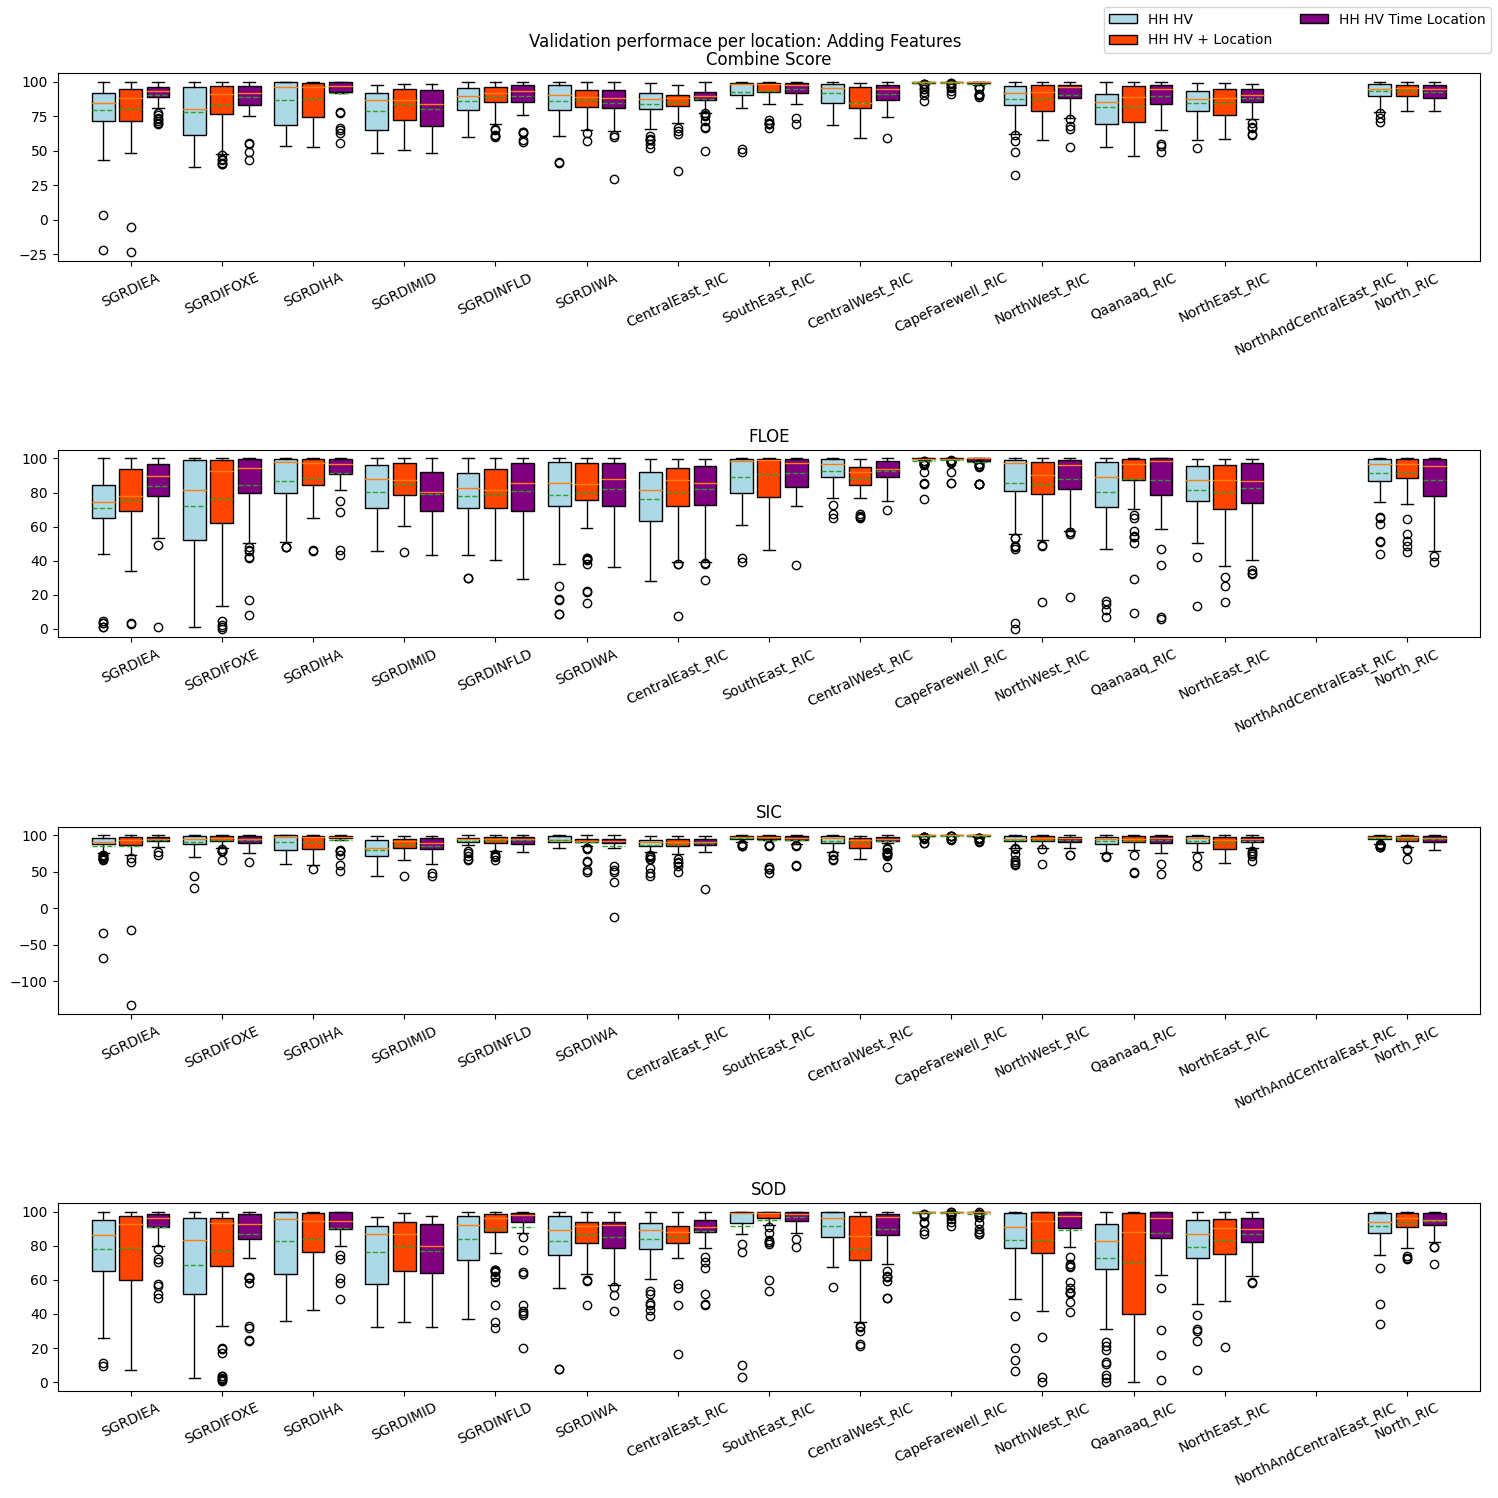

In [6]:

def convert_to_df(data_dic):
        """
        This function converts a the dictionary of data given by performace_per_month to a dataframe.
        Not all information is conserved. 

        Parameters:
        data_dic (dict): The dictionary containing the data to be converted.

        Returns:
        pd.DataFrame: A DataFrame containing the data from the input dictionary.
        """
    
        data = {'Locations':data_dic['Locations'],
                'Combine Score Avg':data_dic['Combine Score']['avg'],
                'Combine Score Std':data_dic['Combine Score']['std'],
                'SIC Avg':data_dic['SIC']['avg'],
                'SIC Std':data_dic['SIC']['std'],
                'SOD Avg':data_dic['SOD']['avg'],
                'SOD Std':data_dic['SOD']['std'],
                'FLOE Avg':data_dic['FLOE']['avg'],
                'FLOE Std':data_dic['FLOE']['std'],
                'sample _number':data_dic['sample_num']
                }
        return pd.DataFrame(data)
    
df_HH_HV = convert_to_df(HH_HV_mean_dic)
display(df_HH_HV)
df_HH_HV.to_csv('location_performace/HH_HV_only.csv',index=False)

df_location = convert_to_df(Location_mean_dic)
display(df_location)
df_location.to_csv('location_performace/HH_HV_location.csv',index=False)


df_time_location = convert_to_df(Time_Location_mean_dic)
display(df_time_location)
df_time_location.to_csv('location_performace/HH_HV_Time_location.csv',index=False)


bar_width = 0.25



locations = ['SGRDIEA','SGRDIFOXE', 'SGRDIHA', 'SGRDIMID', 'SGRDINFLD', 'SGRDIWA', 'CentralEast_RIC', 
                 'SouthEast_RIC', 'CentralWest_RIC', 'CapeFarewell_RIC', 'NorthWest_RIC', 'Qaanaaq_RIC', 
                 'NorthEast_RIC', 'NorthAndCentralEast_RIC', 'North_RIC']



x =  np.arange(len(HH_HV_mean_dic['Locations']))



fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Validation performace per location: Adding Features')

bp1 = axs[0].boxplot(HH_HV_mean_dic['Combine Score']['array'],positions=x-1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True,meanline='True', boxprops=dict(facecolor='lightblue'))
bp2 = axs[0].boxplot(Location_mean_dic['Combine Score']['array'],positions=x+0.0*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='orangered'))
bp3 = axs[0].boxplot(Time_Location_mean_dic['Combine Score']['array'],positions=x+1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='purple'))

axs[0].set_xticks(x,labels=HH_HV_mean_dic['Locations'],rotation = 25)
axs[0].set_title('Combine Score')

axs[1].boxplot(HH_HV_mean_dic['FLOE']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].boxplot(Location_mean_dic['FLOE']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[1].boxplot(Time_Location_mean_dic['FLOE']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[1].set_xticks(x,labels=HH_HV_mean_dic['Locations'],rotation = 25)
axs[1].set_title('FLOE')

axs[2].boxplot(HH_HV_mean_dic['SIC']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[2].boxplot(Location_mean_dic['SIC']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[2].boxplot(Time_Location_mean_dic['SIC']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[2].set_xticks(x,HH_HV_mean_dic['Locations'],rotation = 25)
axs[2].set_title('SIC')


axs[3].boxplot(HH_HV_mean_dic['SOD']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[3].boxplot(Location_mean_dic['SOD']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[3].boxplot(Time_Location_mean_dic['SOD']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[3].set_xticks(x,HH_HV_mean_dic['Locations'],rotation = 25)
axs[3].set_title('SOD')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['HH HV', 'HH HV + Location', 'HH HV Time Location'],ncols=2,loc='outside upper right')

# plt.subplots_adjust(top = 0.99, bottom=0.50, hspace=0.75, wspace=0.4)
fig.tight_layout(h_pad=5, w_pad=5)
plt.show()

In [8]:

database = "datalists/dataset.json"

path = 'ai4arctic/feature_selection_rerun_inference'
group = 'rerun_base'

base_mean_dic, base_relative_mean_dic = performace_per_location(path,group,database)


path = 'ai4arctic/feature_selection_rerun_inference'
group = 'remove_location'

remove_location_mean_dic, remove_location_relative_mean_dic = performace_per_location(path,group,database)


path = 'ai4arctic/feature_selection_rerun_inference'
group = 'remove_time_location'

remove_time_location_mean_dic, remove_time_location_relative_mean_dic = performace_per_location(path,group,database)

wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


/tmp/ipykernel_12826/342030091.py:106: RuntimeWarning: Mean of empty slice.
  metric_dict['avg'] = metric_dict['array'].mean()
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fernando/anaconda3/envs/AI4Artic_torch_2/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_12826/342030091.py:114: RuntimeWar

appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


wandb:   1 of 1 files downloaded.  


appended val table


,Locations,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,SGRDIEA,84.981925,16.412527,87.732439,27.241387,86.805757,12.557355,75.832954,23.252223,66
1,SGRDIFOXE,87.899356,8.917446,92.793489,9.578734,88.287356,11.880174,77.334756,22.520027,45
2,SGRDIHA,91.131643,12.253189,93.643251,10.538451,87.997357,17.430504,92.377214,10.764046,28
3,SGRDIMID,86.792789,9.338365,89.331658,8.060939,84.716500,12.415288,85.867315,10.817585,38
4,SGRDINFLD,90.218100,7.497634,92.529275,5.900513,93.582500,10.437644,78.867050,17.349794,40
5,SGRDIWA,89.946353,7.391252,92.561098,5.520508,91.549804,7.893950,81.509667,21.844110,51
6,CentralEast_RIC,86.295040,11.042499,90.739060,8.379129,86.825060,15.804646,76.346860,19.977403,50
7,SouthEast_RIC,93.147273,6.159703,95.180182,3.441006,94.407181,7.290102,86.561001,14.885292,22
8,CentralWest_RIC,93.019782,7.658743,94.763283,4.099753,91.272631,14.452162,93.027109,9.022612,46
9,CapeFarewell_RIC,98.871000,2.722744,98.898538,2.256456,99.139539,2.769275,98.278692,4.727627,39


,Locations,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,SGRDIEA,87.332449,14.813508,88.809188,24.952919,89.074391,11.355935,80.895391,19.541653,69
1,SGRDIFOXE,88.339478,11.223963,94.373283,5.492155,86.706820,14.824729,79.537030,25.713924,67
2,SGRDIHA,91.868179,10.815037,93.687036,10.259711,89.632392,14.015935,92.702392,10.454289,28
3,SGRDIMID,83.069415,10.193427,87.854547,8.166864,79.920698,15.843847,79.796736,12.746460,53
4,SGRDINFLD,84.165772,15.309793,91.074621,7.508549,83.426212,25.993414,71.827151,21.372157,66
5,SGRDIWA,86.879778,8.943257,92.218148,5.580767,86.059074,12.359748,77.844852,24.665755,54
6,CentralEast_RIC,87.823560,10.092713,91.462300,7.631594,88.046519,13.272602,80.099961,17.782565,50
7,SouthEast_RIC,91.744605,8.120818,93.640605,6.537673,92.127605,9.833943,87.186816,15.264716,38
8,CentralWest_RIC,92.557613,6.045207,95.050326,3.409890,90.192122,11.086115,92.303347,7.184947,49
9,CapeFarewell_RIC,97.828774,4.081386,98.167642,3.348901,98.013019,4.353434,96.782359,6.232497,53


,Locations,Combine Score Avg,Combine Score Std,SIC Avg,SIC Std,SOD Avg,SOD Std,FLOE Avg,FLOE Std,sample _number
0,SGRDIEA,85.776471,17.852582,87.586981,30.310283,86.880235,14.139377,79.947824,20.115988,51
1,SGRDIFOXE,88.267133,10.320697,93.575333,9.090570,86.336577,14.057713,81.511555,21.143155,45
2,SGRDIHA,87.595960,15.465933,90.709759,13.440174,84.427320,19.815208,87.705480,15.668892,25
3,SGRDIMID,84.471750,10.632345,86.590938,11.437301,82.299594,12.841047,84.578000,11.975006,32
4,SGRDINFLD,86.608600,12.350772,91.611527,6.950639,86.688819,20.781414,76.442146,19.194539,55
5,SGRDIWA,88.111437,8.874779,92.128563,5.965543,87.032354,10.793222,82.235312,19.195042,48
6,CentralEast_RIC,85.236373,10.888615,90.598452,6.972238,86.233980,16.765494,72.516941,23.742464,51
7,SouthEast_RIC,92.330250,8.377420,93.921361,7.635985,93.602500,9.437177,86.604027,15.767743,36
8,CentralWest_RIC,91.118196,8.626158,94.518683,4.011504,87.324000,17.578450,91.905537,8.115797,41
9,CapeFarewell_RIC,99.466878,1.129958,99.292653,1.622230,99.682266,1.052853,99.385041,1.498963,49


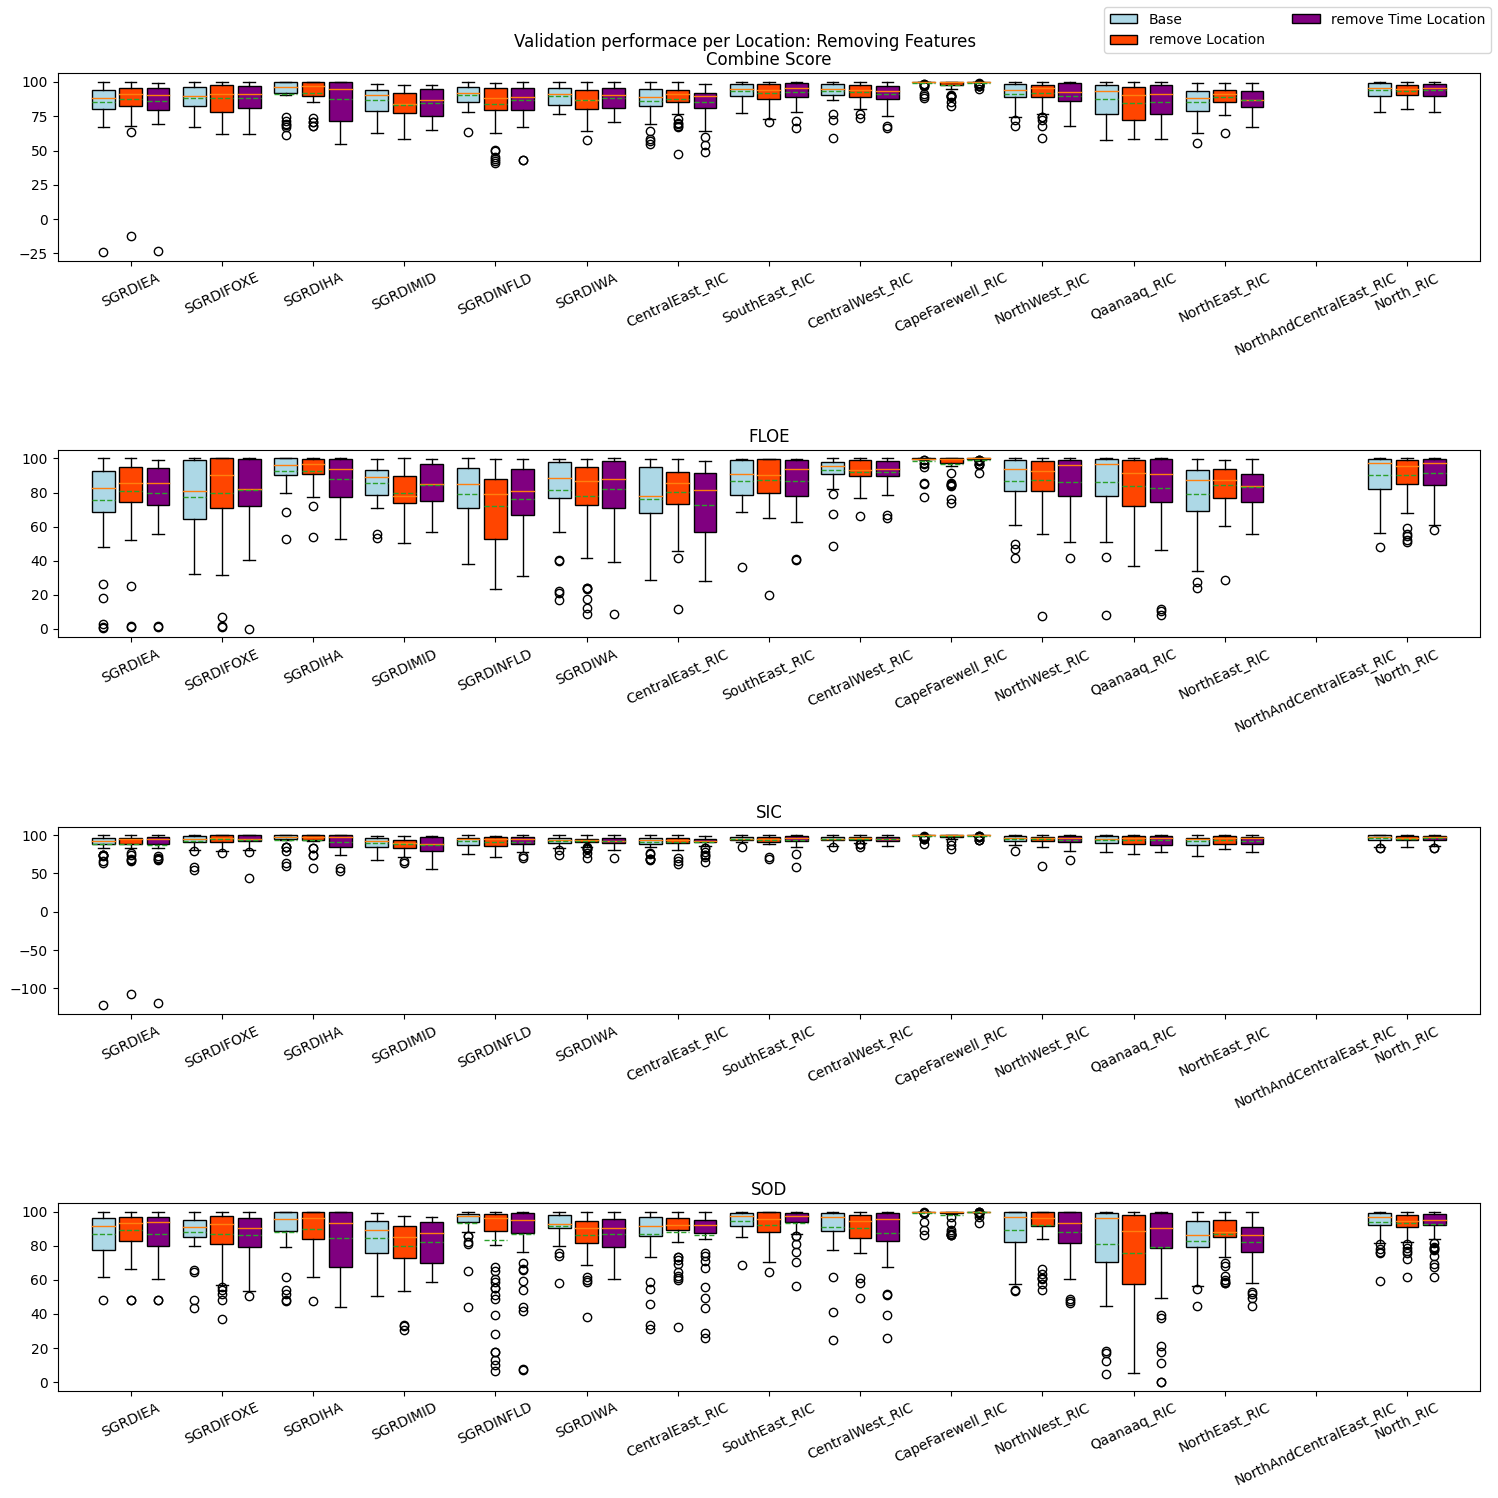

In [9]:
df_base = convert_to_df(base_mean_dic)
display(df_base)
df_base.to_csv('location_performace/base.csv',index=False)

df_remove_location = convert_to_df(remove_location_mean_dic)
display(df_remove_location)
df_remove_location.to_csv('location_performace/remove_location.csv',index=False)

df_remove_time_location = convert_to_df(remove_time_location_mean_dic)
display(df_remove_time_location)
df_remove_time_location.to_csv('location_performace/remove_time_location.csv',index=False)


bar_width = 0.25

locations = ['SGRDIEA','SGRDIFOXE', 'SGRDIHA', 'SGRDIMID', 'SGRDINFLD', 'SGRDIWA', 'CentralEast_RIC', 
                 'SouthEast_RIC', 'CentralWest_RIC', 'CapeFarewell_RIC', 'NorthWest_RIC', 'Qaanaaq_RIC', 
                 'NorthEast_RIC', 'NorthAndCentralEast_RIC', 'North_RIC']

x =  np.arange(len(base_mean_dic['Locations']))

fig, axs = plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Validation performace per Location: Removing Features')

bp1 = axs[0].boxplot(base_mean_dic['Combine Score']['array'],positions=x-1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True,meanline='True', boxprops=dict(facecolor='lightblue'))
bp2 = axs[0].boxplot(remove_location_mean_dic['Combine Score']['array'],positions=x+0.0*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='orangered'))
bp3 = axs[0].boxplot(remove_time_location_mean_dic['Combine Score']['array'],positions=x+1.2*bar_width, widths=bar_width, patch_artist=True,
               showmeans=True, meanline='True', boxprops=dict(facecolor='purple'))

axs[0].set_xticks(x,labels=base_mean_dic['Locations'],rotation = 25)
axs[0].set_title('Combine Score')

axs[1].boxplot(base_mean_dic['FLOE']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].boxplot(remove_location_mean_dic['FLOE']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[1].boxplot(remove_time_location_mean_dic['FLOE']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[1].set_xticks(x,labels=base_mean_dic['Locations'],rotation = 25)
axs[1].set_title('FLOE')

axs[2].boxplot(base_mean_dic['SIC']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[2].boxplot(remove_location_mean_dic['SIC']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[2].boxplot(remove_time_location_mean_dic['SIC']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[2].set_xticks(x,base_mean_dic['Locations'],rotation = 25)
axs[2].set_title('SIC')


axs[3].boxplot(base_mean_dic['SOD']['array'],positions=x-1.2*bar_width, widths=bar_width, 
               showmeans=True, meanline='True', patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[3].boxplot(remove_location_mean_dic['SOD']['array'],positions=x+0.0*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='orangered'))
axs[3].boxplot(remove_time_location_mean_dic['SOD']['array'],positions=x+1.2*bar_width, widths=bar_width,
               showmeans=True,meanline='True', patch_artist=True, boxprops=dict(facecolor='purple'))

axs[3].set_xticks(x,base_mean_dic['Locations'],rotation = 25)
axs[3].set_title('SOD')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Base', 'remove Location', 'remove Time Location'],ncols=2,loc='outside upper right')

# plt.subplots_adjust(top = 0.99, bottom=0.50, hspace=0.75, wspace=0.4)
fig.tight_layout(h_pad=5, w_pad=5)
plt.show()


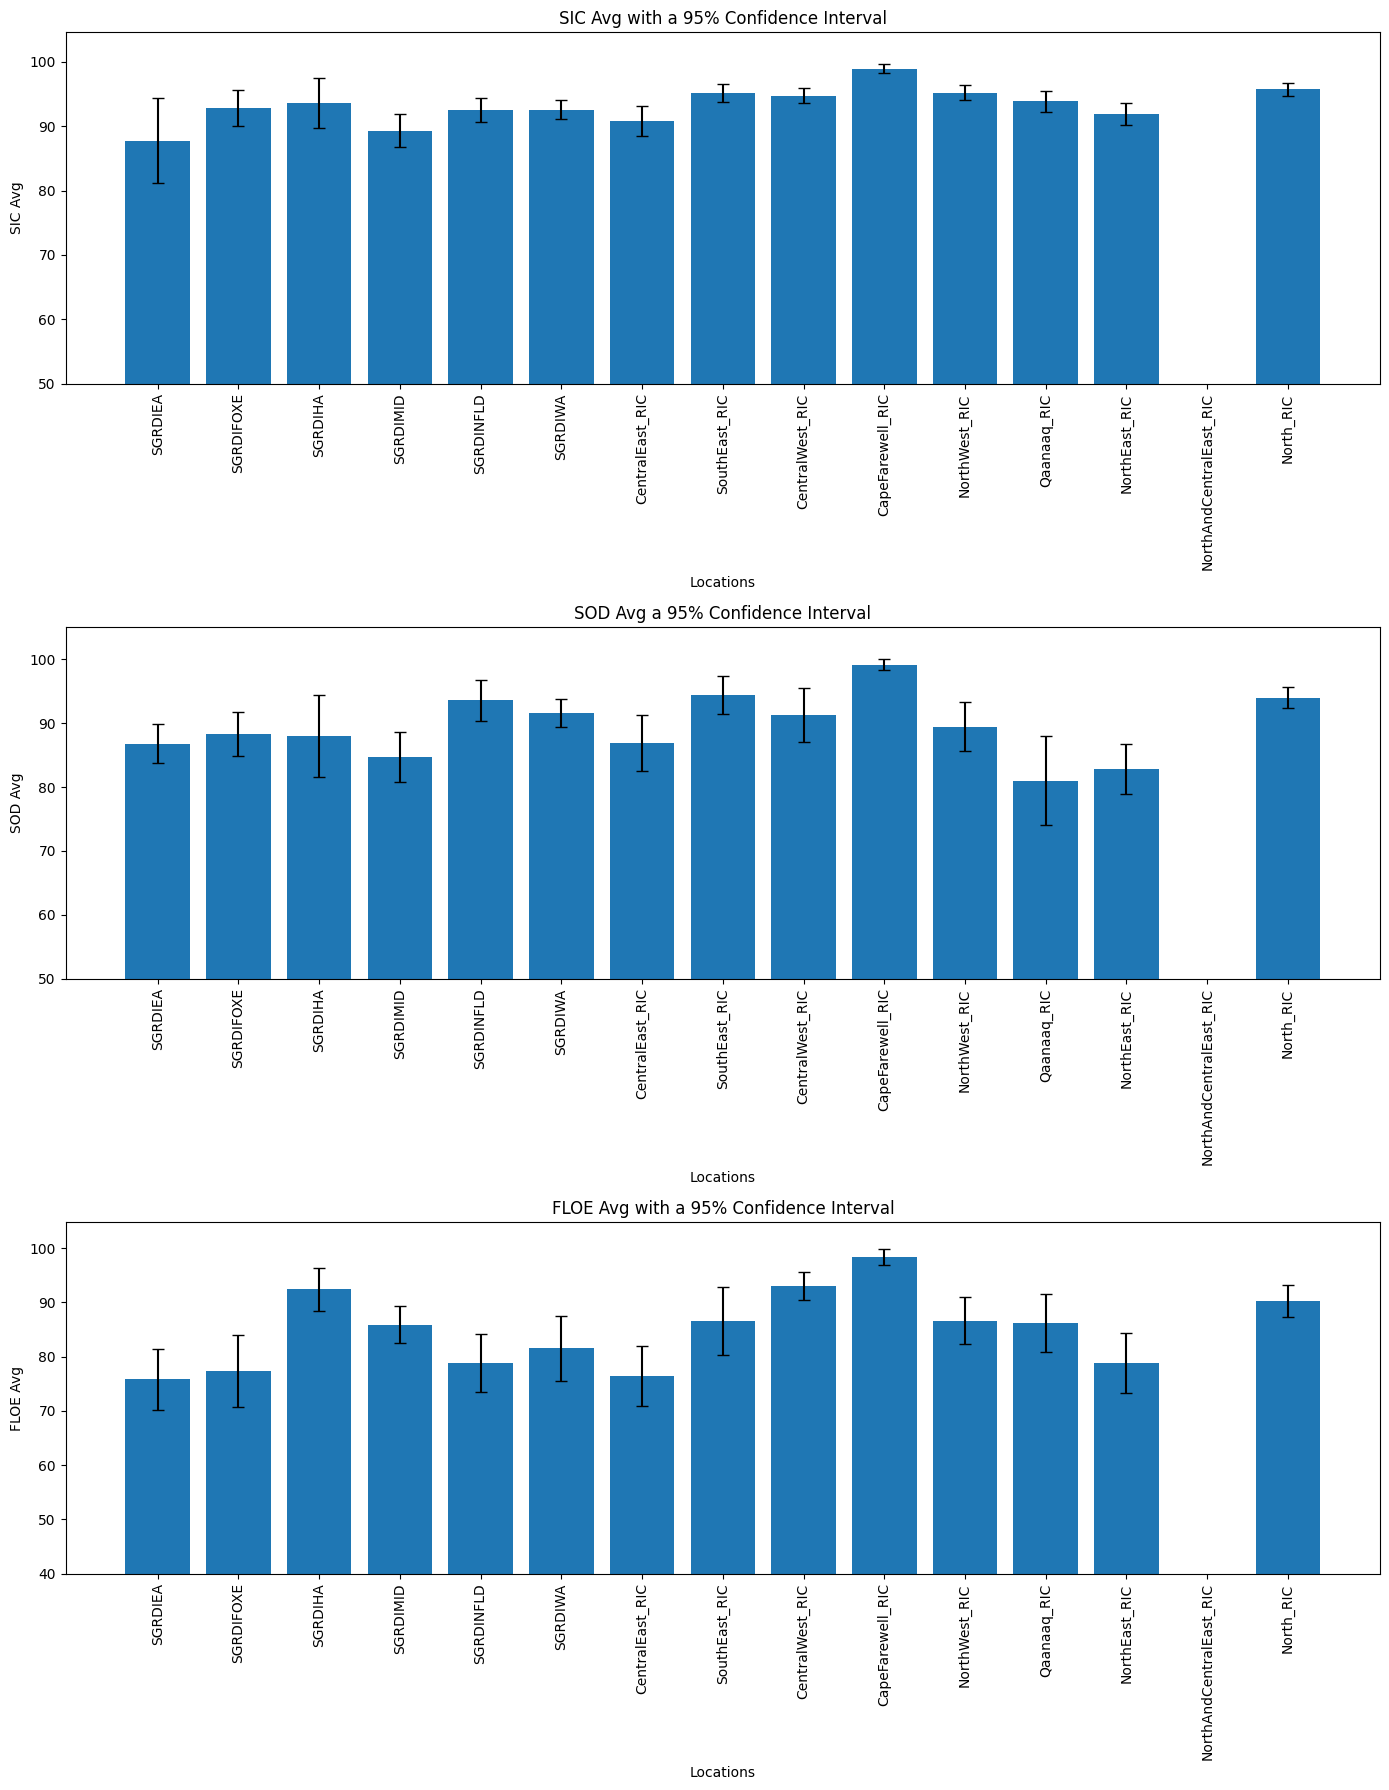

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file
csv_path = 'location_performace/base.csv'
data = pd.read_csv(csv_path)

# Now we will create bar charts with standard deviation for SIC, SOD, and FLOE.

# Setting up the plotting area (subplots for each variable)
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Titles for the plots
titles = ['SIC Avg with a 95% Confidence Interval', 'SOD Avg a 95% Confidence Interval', 'FLOE Avg with a 95% Confidence Interval']

# Columns to plot
columns = ['SIC Avg', 'SOD Avg', 'FLOE Avg']
std_columns = ['SIC Std', 'SOD Std', 'FLOE Std']
y_limits = [50,50,40]

# Plotting each bar chart
for ax, col, std_col, title, y_lim in zip(axes, columns, std_columns, titles, y_limits):
    se = data[std_col]/np.sqrt(data['sample _number'])
    ax.bar(data['Locations'], data[col], yerr=1.96*se, capsize=4)
    ax.set_title(title)
    ax.set_xlabel('Locations')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(y_lim)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot as a PNG image
# image_path = '/mnt/data/bar_charts_with_std.png'
# plt.savefig(image_path)